# Final project Anna van Tiel
For the final project, I will be working on my own data. Since my study field is biomedical sciences, I want to do something biology related. Currently, I am not working on data in an internship or project, but online there is a lot of data open available that you can apply your own analysis on. In this project I will work on protein homology across different species.

To give some background, proteins with similar functions are categorised into protein families. A well-known protein category in animals is the category of protein kinases, which act upstream of some common cell signalling pathways. One family within these is the protein kinase B, also known as Akt1. Akt1 has a particular domain which is the Pleckstrin-homology (PH) domain which binds the cell membrane. Akt1 functions through localising at the cell membrane and then phosphorylating other proteins at their serine and threonine residues. As a result, the phosphorylated proteins are activated and can intiate cellular processes.

Regarding its essential role in cellular function, Akt1 is an essential gene in many species. In this project I am going to take a closer look at them and how they compare across species. The main questions are:

- Is there evidence for evolutionary pressure on the Akt1 protein?

Hypothesis: because Akt1 is essential for cellular function, I expect that there is evolutionary pressure on some parts of the protein, in particular the sequences (residues) that fall within a specific domain with its own function, such as the PH or catalytic domain.

The coding sequences (CDS) of many genes are available in biological databases as `.fasta` files. I will use the most common database, which is the National Centre for Biotechnology Information (NCBI). I am going to compare `fasta` sequences of the Akt1 CDS from 6 different species using the `Biopython` library: human, rat, rhesus monkey, fruit fly, zebra fish, and chicken. I will download and analyse the CDS and Biopython has a tool to translate them into (linear) amino acid sequences.


Note: sometimes to be a bit shorter, I refer to amino acid as aa in code, for instance `aa_record` rather than `amino_acid_record`.

Note 2: in two cells in the notebook I use subprocess to pipe a command through to the bash command-line. The following packages need to be installed to completely run this notebook:
- `conda install -c bioconda clustalw`
- `conda install -c bioconda hmmer`

Bioconda specialises in bioinformatics software. Alternatively, the output files of these two commands are saved in the ./data folder on my Github repository. 

Note 3: Biopython is updated a lot because of evolving demands from the bio-informatics field. This version was **written for and is dependent on Biopython version 1.85**, and might not work for previous or future versions, especially the motif module!

In [1]:
# general python libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

# biopython libraries
from Bio import SeqIO, Align, AlignIO, Phylo, motifs		# need to have biopython installed -> pip install biopython
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment, PairwiseAligner
from Bio.SeqRecord import SeqRecord
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# supporting libraries
import subprocess
from collections import Counter
from pathlib import Path
import peptides 											# need to have peptides installed -> pip install peptides

In `Biopython`, you can create `SeqRecord` class objects which can hold sequences such as DNA or amino acid sequences. Here I will assign each amino acid sequence in each `.FASTA` file to a dictionary with the organism name as key and the sequences of individual proteins in lists via an intermediate `SeqRecord` object. Here, I will import `.fa` files which are DNA specific `.FASTA` sequences.

`Seq` objects are only the sequences, `SeqRecord` objects contain additional annotation information. `.fasta` files contain extra annotation information (every line starting with `>`) and can only be imported as `SeqRecord` objects using `.read()`. I will use this to translate my DNA sequence into an amino acid sequence for each organism using `.translate()`. Then I can store the amino acid sequences in a new `.fasta` file for later use.

In [2]:
species = ["D_melanogaster", "D_rerio", "G_gallus", "R_norvegicus", "M_mulatta", "H_sapiens"]

trivial_species = ["fruit_fly", "zebrafish", "chicken", "rat", "rhesus_monkey", "human"]

# create a mapping dictionary to link trivial names to scientific names
scientific_to_trivial = {scientific: trivial for scientific, trivial in zip(species, trivial_species)}

# veryify correct mapping
print("\nCheck correct mapping")
print(scientific_to_trivial)

# now read .fa files and store the record.ids, DNA sequences, and amino acid sequences in a nested dictionary
Akt1 = {"fruit_fly": {}, "zebrafish": {}, "chicken": {}, "rat": {}, "rhesus_monkey": {}, "human": {}}

# use open() function to write results of translation
with open("./data/Akt1_amino_acid_sequences/translated_Akt1_sequences.fasta", "w") as aa_filename:
    for file in species:
        dna_record = SeqIO.read(f"./data/Akt1_dna_sequences/{file}_Akt1.fa", "fasta")
        aa_sequence = dna_record.seq.translate()

        # store amino acid sequence as .fasta file
        aa_record = SeqRecord(aa_sequence, id=dna_record.id, description=f"translated {file} Akt1")
        SeqIO.write(aa_record, aa_filename, "fasta")

        # also add record.ids, dna and amino acid sequences to Akt1 dictionary
        # replace : to _ in ids to allow file storage
        Akt1[scientific_to_trivial[file]]["ID"] = dna_record.id.replace(":", "_")
        Akt1[scientific_to_trivial[file]]["DNA_seq"] = dna_record.format("fasta")
        Akt1[scientific_to_trivial[file]]["AA_seq"] = aa_record.format("fasta")

#print("\nCheck correct storing of results:")
#print(Akt1["fruit_fly"])


Check correct mapping
{'D_melanogaster': 'fruit_fly', 'D_rerio': 'zebrafish', 'G_gallus': 'chicken', 'R_norvegicus': 'rat', 'M_mulatta': 'rhesus_monkey', 'H_sapiens': 'human'}


Now I want to align the protein sequences, to see how similar they are and more importantly, which organisms are more similar to each other. ClustalW is a nice command-line tool for this. It aligns sequences and returns two files, `.aln` and `.dnd` files, which contain the alignment and a phylogenetic tree which can be read into Python. I can use subprocess to pipe the command from Python into the command-line.

Since it is common to inspect genetic hierarchy using DNA, not proteins, I also align the DNA sequences, for which I first need to merge the `.fa` files into one.

Note: if the command does not work during checking of my assignment, no worries because the output files are available as `translated_Akt1_sequences.aln` and `translated_Akt1_sequences.dnd` (and similar for aligned DNA sequences) in my git repository in data.

In [3]:
# run alignment on protein file
# need to run alignment twice to get both .aln and .dnd output
cmds = ["clustalw -INFILE=./data/Akt1_amino_acid_sequences/translated_Akt1_sequences.fasta -OUTFILE=./alignments/protein.aln",
        "clustalw -INFILE=./data/Akt1_amino_acid_sequences/translated_Akt1_sequences.fasta -NEWTREE=./alignments/protein.dnd"]
for cycle, cmd in enumerate(cmds):
    results = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, text=True)

    # only print output once
    if cycle == 0:
        print("\nresults peptide alignment:")
        print(results.stdout)

# merge .fa files, then run alignment on dna file
with open("./data/Akt1_dna_sequences/merged_Akt1_dna_sequences.fa", "w") as merge_filename:
    for file in species:
        dna_record = SeqIO.read(f"./data/Akt1_dna_sequences/{file}_Akt1.fa", "fasta")
        SeqIO.write(dna_record, merge_filename, "fasta")

# run alignment on dna file
cmds = ["clustalw -INFILE=./data/Akt1_dna_sequences/merged_Akt1_dna_sequences.fa -OUTFILE=./alignments/dna.aln",
        "clustalw -INFILE=./data/Akt1_dna_sequences/merged_Akt1_dna_sequences.fa -NEWTREE=./alignments/dna.dnd"]

for cycle, cmd in enumerate(cmds):
    results = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, text=True)

    if cycle == 0:
        print("\nresults DNA alignment:")
        print(results.stdout)


results peptide alignment:



 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence format is Pearson
Sequence 1: NT_033777.3_16099228-16105670      611 aa
Sequence 2: NC_007128.7_1437407-1537044        247 aa
Sequence 3: NC_052536.1_c51173536-51102404     518 aa
Sequence 4: NC_086024.1_c137555131-137534810   498 aa
Sequence 5: NC_041760.1_c167123096-167093460   480 aa
Sequence 6: NC_000014.9_c104795748-104769349   480 aa
Start of Pairwise alignments
Aligning...

Sequences (1:2) Aligned. Score:  65
Sequences (1:3) Aligned. Score:  56
Sequences (1:4) Aligned. Score:  50
Sequences (1:5) Aligned. Score:  61
Sequences (1:6) Aligned. Score:  61
Sequences (2:3) Aligned. Score:  91
Sequences (2:4) Aligned. Score:  60
Sequences (2:5) Aligned. Score:  90
Sequences (2:6) Aligned. Score:  90
Sequences (3:4) Aligned. Score:  73
Sequences (3:5) Aligned. Score:  93
Sequences (3:6) Aligned. Score:  93
Sequences (4:5) Aligned. Score:  79
Sequences (4:6) Aligned. Score:  79
Sequences (5:6) Aligned. Sco

The first thing I notice is that the peptide pairwise alignments have higher scores than the DNA ones. This makes sense, since over the course of millions of years of evolution, sequencing errors may have resulted in mutations in the DNA. If this results in a different codon (three letter code representing an amino acid), this might lead to a non-functional protein and thus counter-selected by evolution. However, all amino acids have multiple three letter codes (for instance CCC, CCA, and CCG all code for proline), making them accumulate faster because they are not counter-selected in evolution.

The score is in percentages, so DNA sequences 5 and 6 are very similar and peptide sequences 5 and 6 are nearly identical. These correspond to rhesus monkey and human, respectively. On the first note, sequence 1 is the most unique as it has the lowest score with all other sequences in all pairwise alignments. This corresponds to fruit fly.

Next, I will further inspect the alignment and after that, draw a phylogenetic tree. Alignments can be read into `AlignIO` objects, which are just like `SeqIO` (`SeqRecord`) objects (containing annotations) but then for aligned sequences.

In [4]:
align = AlignIO.read("./alignments/protein.aln", "clustal")
print(align)

Alignment with 6 rows and 646 columns
--------------------------------------------...RFL NC_086024.1_c137555131-1375348
--------------------------------------------...--- NC_000014.9_c104795748-1047693
--------------------------------------------...--- NC_041760.1_c167123096-1670934
--------------------------------------------...--- NC_052536.1_c51173536-51102404
--------------------------------------------...--- NC_007128.7_1437407-1537044
TNYLPFVLQRRSTVVASAPAPGSASRIPESPTTTGSNIINIIYS...SMQ NT_033777.3_16099228-16105670


This is of course not very insightful yet, especially because one sequence seems to be divergent (fruit fly), with having no matches with the other sequences both at the start and end, suggesting that gaps may exist in the middle and that the alignment might not be very good. This is reflected by the lowest pairwise alignments for those involving fruit fly for both DNA and protein. I can print a few frames further down the sequences to see whether how all sequences align.

There is no direct method to look further in align, but I can use a for loop to manually print the sequences below each other at different index slices.

I have to do a trick during the mapping of species name using the mapping dictionary because the ids in the alignment object seem to be truncated. I do this through splitting at a unique character before the truncated part of the id. Here I use `-`.

In [5]:
# create another mapping dictionary from sequence IDs to species names
id_to_species = {values["ID"]: species for species, values in Akt1.items()}

def show_alignment(AlignIO_object, start, end, clean_ids=True):
    """
    This function prints the alignment
    for amino acids start until end
    using the alignment column indices
    """

    if clean_ids == True:
        # split at -
        for sequence in AlignIO_object:
            trimmed_id = sequence.id.split("-")[0]
        
            # loop over ids in mapping dictionary to match species, break when found
            for species_id, species in id_to_species.items():
                if trimmed_id == species_id.split("-")[0]:
                    seq_species = species
                    break
        
            print(f">{seq_species}\n{sequence.seq[start:end]}")
    else:
        for sequence in AlignIO_object:
            print(f">{sequence.id}\n{sequence.seq[start:end]}")
        

for i in range(4):
    print(f"\nFragment {i+1}: {i * 200}:{i * 200 + 100}")
    show_alignment(align, i * 200, i * 200 + 100)


Fragment 1: 0:100
>rat
----------------------------------------------------------------------------------------------------
>human
----------------------------------------------------------------------------------------------------
>rhesus_monkey
----------------------------------------------------------------------------------------------------
>chicken
-----------------------------------------------------------------------------------------MVTKYLENIFL
>zebrafish
----------------------------------------------------------------------------------------------------
>fruit_fly
TNYLPFVLQRRSTVVASAPAPGSASRIPESPTTTGSNIINIIYSQSTHPNSSPTSGSAEKFSWQQSWPSRTSAAPTHDSGTMSINTTFDLSSPSVTSGHA

Fragment 2: 200:300
>rat
TFIIRCLQWTTVIERTFHVETPEEREEWTTAIQTVADGLK---------RQEEETMDFRSGSPSDNSGAEEMEVA----LAKPKHRVTMNEFEYLKLLGK
>human
TFIIRCLQWTTVIERTFHVETPEEREEWTTAIQTVADGLK---------KQEEEEMDFRSGSPSDNSGAEEMEVS----LAKPKHRVTMNEFEYLKLLGK
>rhesus_monkey
TFIIRCLQWTTVIERTFHVETPEEREEWTTAIQTVADGLK---------KHEEEMMDFRSGSPSDNS

It seems like the proteins of rat, human, rhesus monkey, and chicken align very well. Zebra fish aligns well in some frames but not so in others where there are gaps. It seems as if this protein was truncated at the start somewhere during evolution, which is also reflected by the significantly shorter protein length (247 amino acids compared to 400-600 for the other species).

I am curious to see whether I can acquire a bit more information about the alignments. First I am interested in how far apart the sequences are. I will print phylogenetic trees for this on both protein and DNA levels. Phylogenetic trees show the distance of entries. You can use them for different things. In biology, they are usually used to show genetic similarity. In this case, I will use them to illustrate the genetic similarity of the Akt1 genes from the different species. The distance computation is done intrinsically and is a bit vague (it is called "distance computation based on identity") so could not really figure out how exactly the formula is, but as is logic, the larger the number along the branch, the larger the genetic distance is and so the more divergent the genes are.

Here I am showing the trees for both DNA and proteins.


Phylogenetic tree for dna


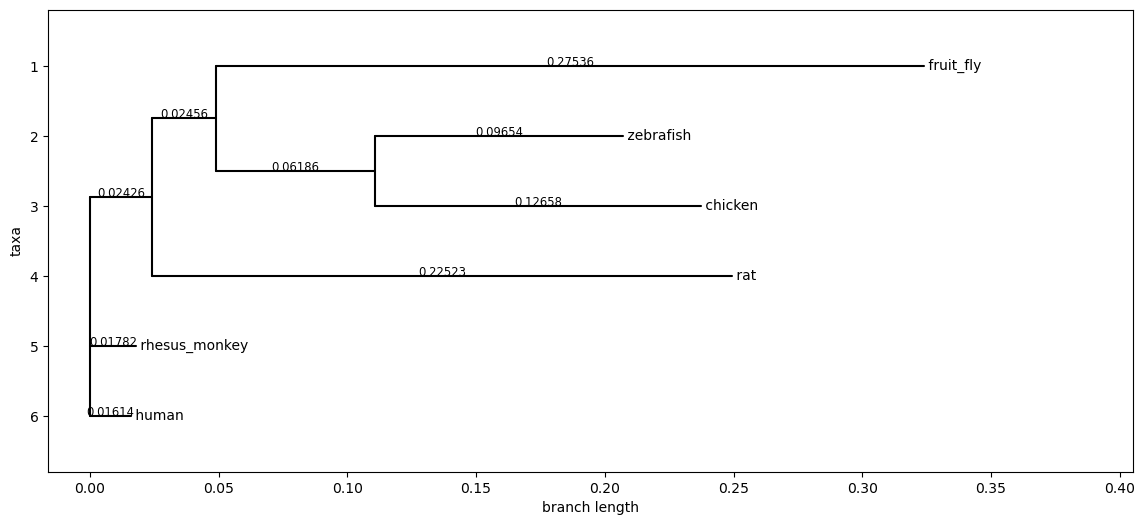


Phylogenetic tree for protein


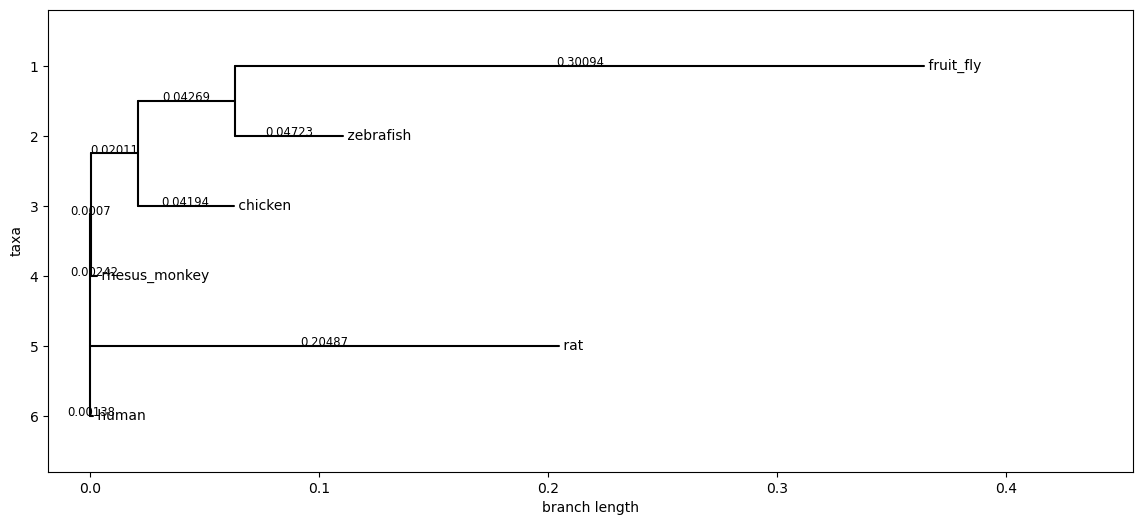

In [27]:
# acquiring files for dna and protein
files = ["./alignments/dna.dnd", "./alignments/protein.dnd"]

# drawing trees
for file in files:

    tree = Phylo.read(file, "newick")
    
    # rename tree labels using dictionary lookup
    for clade in tree.get_terminals():
        clade.name = id_to_species.get(clade.name, clade.name)

    print(f"\nPhylogenetic tree for {file.split('/')[2].split('.')[0]}")
    
    # Phylo.draw() dependency on matplotlib allows manual setting of figure size
    # need a wide figure because branch_labels take a lot of space
    fig, ax = plt.subplots(figsize=(14, 6))
    Phylo.draw(tree, branch_labels=lambda c: c.branch_length, axes=ax)

    # save file then close
    output_filename = f"./results/{file.split('/')[2].split('.')[0]}_tree.png"
    fig.savefig(output_filename, dpi=300)
    plt.close()

These trees tells us how close together human, rhesus monkey, and rat are compared to chicken, zebrafish, and fruit fly. Especially rhesus monkey and human are very close together, which is not strange regarding monkey and human are evolutionary the closest relatives with the most recent common ancestor. This tree raises a few questions, which fall in the scope of the more general research question above:

- Some species appear to be closer together than others. Is there any direct evidence that rhesus monkey, rat, and human DNA are closer together than the other species? What substitutions have resulted in divergence?
- Can I distinguish particular protein motifs which are conserved across all species?
- If motifs can be distinguished, can we identify them as (part of) specific protein domains?
- Human and rhesus monkey are the closest together. What is the most recent common ancestor of the two closest related (rhesus monkey and human)?

The last question might be a bit hard to answer but I could do a BLAST search (Basic Local Alignment Search Tool) to identify other similar genes in other species. In general with these questions, I will see how far I get with them.

## Are rhesus monkey, rat, and human closer together than the other species?

To answer this question, I need to dive deeper into the indivual sequences. First let's check whether the amino acid division profiles clearly differ between proteins. I will do this by plotting a stacked bar graph with counts per amino acid per organism. So if one amino acid is strongly under- or overrepresented in a certain organism, this will instantly be visible because the organism ratios are different compared to other bars.

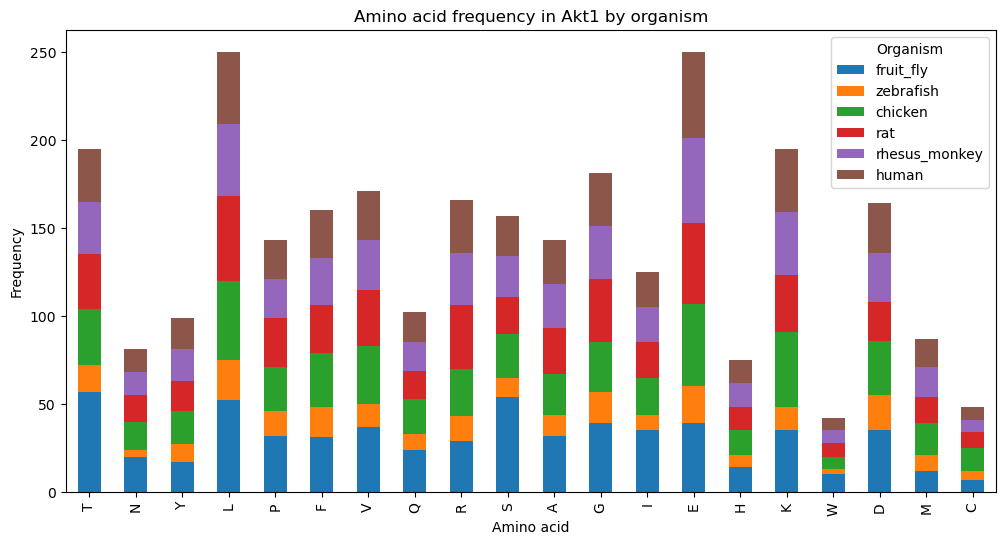

In [7]:
organisms = {}
for organism, keys in Akt1.items():

    # remove .fasta header through splitting at first newline and indexing the seond item
    aa_seq = keys["AA_seq"].split("\n", 1)[1]

    # count all amino acids but not unknown * using Counter object
    organisms[organism] = Counter(aa_seq.replace("*", "").replace("\n", ""))

# put counts in df for plotting
df = pd.DataFrame.from_dict(organisms)

# plot stacked bar plot
ax = df.plot.bar(stacked=True, figsize=(12, 6))
ax.set_xlabel("Amino acid")
ax.set_ylabel("Frequency")
ax.set_title("Amino acid frequency in Akt1 by organism")
plt.legend(title="Organism")

# save plot
output_filename = "./results/amino_acid_frequency_by_organism.png"
plt.savefig(output_filename, dpi=300)

# show plot then close
plt.show()
plt.close()

I do not instantly spot major skewed ratios, although tryptophan (W) appears to be slightly overrepresented in fruit fly Akt1. This is, however, a minor difference which can also be seen in some other amino acids. In general, fruit fly and zebrafish were the most divergent proteins, so we can expect the most changes in ratios there.

Next, I will store the amino acid sequences as `peptide` class from the `peptide` library, allowing me to call methods which provide information about the aliphatic index (relative volume occupied by aliphatic side chains of peptides, where **aliphatic side chains** are non-aromatic hydrocarbon chains or **hydrophobic chains**) and charge at certain pH (7.4 is intersting, physiological pH). This tells us something about the chemical state of each protein and could indicate whether they are similar.

In [8]:
peptide_objects = {}

for organism in Akt1.keys():
    peptide = (Akt1[organism]["AA_seq"].split("\n", 1)[1].replace("*", "").replace("\n", ""))
    peptide_objects[organism] = peptides.Peptide(peptide)

# compare chemical properties of Akt1 per organism
print("\naliphatic index:")
for organism, pep in peptide_objects.items():
    print(f"{organism}: ", pep.aliphatic_index())

print("\ncharge at physiological pH (7.4):")
for organism, pep in peptide_objects.items():
    print(f"{organism}: ", pep.charge(pH=7.4))


aliphatic index:
fruit_fly:  78.33060556464811
zebrafish:  70.64777327935224
chicken:  72.60617760617761
rat:  77.10843373493977
rhesus_monkey:  71.6875
human:  71.6875

charge at physiological pH (7.4):
fruit_fly:  -10.494061891683067
zebrafish:  -14.46143969534818
chicken:  -9.35330986168287
rat:  -0.8122169356628453
rhesus_monkey:  -10.491821941019763
human:  -11.529400999950305


From the trees earlier, we could see that the Akt1 protein of species are related. The Rat protein has its own branch in the tree, but still I concluded that human, rhesus monkey, and rat are the most related species when it comes to Akt1. Interestingly, although the aliphatic index reflects structural similarity between the proteins, the rat protein has a much less strong charge (closer to 0). This may indicate that the protein has **more basic residues** (+ charge) or **fewer acidic residues** (- charge). This we cannot possibly see from the graph or by just looking at the sequences. Luckily, the substitutions property of an alignment can provide more information about single amino acid mutations.

The substitutions property reports how often amino acids in the alignment are substituted for each other. This is calculated by taking all pairs of rows in the alignment, counting the number of times two letters are aligned to each other, and summing this over all pairs. It is thus a pairwise alignment within the multiple sequence alignment! The output is a 2 dimenstional array with rows and columns containing all (in this case) amino acids present in the sequences. And example in the Biopython documentation is this:


For alignment

```
seq 1: ACTCCTA
seq 2: AAT-CTA
seq 3: CCTACT-
seq 4: TCTCCTC
```

The substitution matrix looks like this:

```
   A    C    T
A 2.0  4.5  1.0
C 4.5 10.0  0.5
T 1.0  0.5 12.0
```


You have to read it like this:

How many times has [row_nucleotide] changed to [column_nucleotide]? This is only the average of both directions:
- $\frac{[row nucleotide] -> [column nucleotide]) + ([column nucleotide] -> [row nucleotide])}{2}$
- So to be short, it is the sum of pairwise comparison conflicts divided by 2 (for 2 directions)


So in the example matrix:
- A -> C or C -> A: occurs approximately 4.5 times across all sequences.
- C -> C (no change, so conserved): occurs approximately 10.0 times across all sequences (division by 1 because only 1 direction)

The absolute values which are dependent on the alignment length, are less important than their relative differences. It is mostly about **the number relative to the other numbers**. What you can tell from the example matrix is that T is very conserved because it was mutated into another nucleotide only 1.5 times across all sequences (1.0 + 1.5) compared to 12.0 times conserved (and vice versa T replaced A or C 1.5 times), whereas A is not very conserved since it is only conserved 2.0 times compared to 4.5 + 1.0 = 5.5 times mutated into C or T, respectively across all sequences. This tells us something about the high evolutionary pressure on T compared to A.

In [9]:
substitutions = align.substitutions
print(substitutions)

      A    C     D     E     F     G     H     I     K     L     M     N     P     Q     R     S     T     V    W     Y
A 212.0  1.5   3.5   0.5   2.5  12.0   8.0   0.5   2.5   0.5   0.0   0.5   2.0  10.5   4.5  21.0  10.0   7.5  1.5   2.5
C   1.5 74.0   0.5   0.0   2.5   2.0   0.0   0.0   2.5   0.0   0.0   0.0   0.5   0.0   4.5   3.0   1.5   2.0  0.0   0.0
D   3.5  0.5 294.0  28.5   2.5  16.5   5.0   0.0   1.5   0.5   2.5   2.0   3.0   1.5   2.5   4.0   3.5   0.0  0.0   2.5
E   0.5  0.0  28.5 441.0   0.0   2.5   2.5   4.5   2.5   6.5   4.5   5.0   4.5  20.5   2.0  18.0  12.0   2.5  0.0   0.0
F   2.5  2.5   2.5   0.0 307.0   2.5   0.5   0.5   0.0   4.5   2.5   2.0   0.5   0.5   2.0   2.5   0.0   6.5  2.5   2.0
G  12.0  2.0  16.5   2.5   2.5 324.0   1.5   0.5   4.5   2.5   0.0   2.5   4.0   6.0   2.0   7.5   2.5   2.0  0.0   0.0
H   8.0  0.0   5.0   2.5   0.5   1.5 119.0   0.0   4.0   0.0   1.5   2.0   5.0   1.5   2.5   1.5   2.5   0.0  0.0   4.0
I   0.5  0.0   0.0   4.5   0.5   0.5   0

This matrix is a bit overwhelming, which is why I want to compute the no mutation value over the sum of change values to give me a meaningfull fraction of conservation. There is no information available in the Biopython documentation of how to interpret the matrix, but I will define the conservation value $C$ as follows:

$C=\frac{S_{self}}{S_{self} + \sum{S_{substitutions}}}$

with $S_{self}$ and $S_{substitutions}$ the no mutation and substitution values, respectively. For each amino acid, the formula will thus return the fraction which was conserved of the total conserved and mutated into some other amino acid.

With this formula, we can see the evolutionary pressure on each amino acid. The higher the score, the more conserved it is across all sequences.

In [29]:
def compute_conservation_scores(AlignIO_object):
    """
    This function computes the conservation
    score for all amino acids across all
    sequences and returns the printed scores
    """

    substitutions = AlignIO_object.substitutions

    # computing conservation scores using element-wise operations across rows
    conservation_matrix = np.max(substitutions, axis=0) / (np.sum(substitutions, axis=0))

    sorted_conservation_matrix = np.sort(conservation_matrix, axis=None)[::-1]

    # need pandas dataframe to sort amino acid labels because you cannot do that in array format
    # for labels i must convert string to list() to acquire characters, then convert to np.array to allow indexing with np.argsort()
    sorted_conservation_matrix = pd.DataFrame({"conservation score": sorted_conservation_matrix}, 
                                              index=np.array(list(substitutions.alphabet))[np.argsort(conservation_matrix)[::-1]])
    
    return sorted_conservation_matrix

conservation_all_sequences = compute_conservation_scores(align)
display(conservation_all_sequences)

,conservation score
Y,0.909091
W,0.900000
F,0.893741
L,0.877384
G,0.820253
K,0.802367
E,0.791031
D,0.786096
C,0.783069
P,0.778702


This is of course across all sequences, but I was mostly interested in the closely related ones, because now there is some noise from very different proteins, especially the fruit fly one which was very different. So let's delete the sequences I am not interested in for now and rerun the code.

In [30]:
def remove_sequences(AlignIO_object, seq_ids_set):
    """
    This function removes sequences with
    IDs seq_ids_list from the AlignIO_object
    """

    # Create a new alignment without the unwanted sequences
    filtered_alignment = MultipleSeqAlignment([sequence for sequence in AlignIO_object if sequence.id not in seq_ids_set])

    return filtered_alignment

# since the IDs were truncated, easiest here is to hardcode the IDs to remove
filtered_align = remove_sequences(align, set(["NT_033777.3_16099228-16105670",
                                              "NC_007128.7_1437407-1537044",
                                              "NC_052536.1_c51173536-51102404"]))

conservation_filtered_sequences = compute_conservation_scores(filtered_align)
display(conservation_filtered_sequences)

,conservation score
W,0.954545
N,0.951220
Y,0.943396
K,0.941176
L,0.937008
F,0.935897
I,0.912281
D,0.897436
V,0.896552
E,0.895105


The relative order of conservation scores remains unchanged, indicating that the hierarchy of residue conservation is consistent across species. This suggests that fundamental structural and functional constraints govern residue conservation universally. The absolute conservation scores increase when comparing only the most closely related species (human, rhesus monkey, and rat). This reflects the higher sequence similarity and thus stronger evolutionary pressure.

This pattern aligns with evolutionary principles:

- Universal conservation profile: The fact that the ranking of residues remains the same across all species supports the idea that fundamental biochemical properties drive residue conservation, regardless of evolutionary distance.
- Higher conservation within closely related species: The increase in conservation scores for human, rhesus monkey, and rat highlights their closer evolutionary relationship, as fewer mutations have accumulated compared to more distant species.

It is clear that human, rhesus monkey, and rat are indeed closer together than the other species.

## Can I distinguish particular protein motifs which are conserved across all species?

Next, I would like to see whether motifs are conserved across all species, and if not, across the most related species.

First, I have to extract conserved **short sequences, rather than single residues**. For this I want to find sequences which are more than or equal to a certain threshold similar in each position. I arbitrarily choose 0.8 (in my code, this means that 80% or more of the aligned sequences have the same amino acid in each position to be considered a conserved sequence). To avoid acquiring single amino acids or sequences of 2 or similar extremely short length, I will set the minimal length to 5.

What the code below does is consider all sequences in the alignment and find all instances where 80% or more of the aligned sequences are identical for at least minimal_length amino acids in a row. For this example, image minimal_length is set to 5. This is considered per spot and not per sequence, so in case my alignment looks like this:
```
       1  2  3  4  5  6  7  8  9  10 11 12
seq 1: A  C  A  K  L  Y  A  T  T  R  Y  L
seq 2: A  C  A  K  L  Y  T  T  T  L  K  L
seq 3: A  G  A  K  L  Y  T  T  T  R  Y  L
seq 4: A  C  A  K  L  Y  T  C  T  R  K  L
seq 5: A  I  A  K  L  Y  T  T  T  R  K  L
```

sequences 1, 2 and 4 are different in positions 7, 10 and 8, respectively, but that does not mean they are excluded because regarding the positions, the sequences are still 80% or more identical.

The start of the conserved sequence is 3, because in 2 only 60% of the sequences are identical and in 1 they are 100% identical, but it is not part of a sequence of at least length 5. The last position of the conserved sequence is 10, because in 11 the sequences are only 60% identical.

The function returns a list of lists. Each list in the list contains all sequences from position start to end of the considered conserved sequence. Later, I use the motif module to calculate consensus sequences.

Actually, because the protein is somewhere between 400 and 600 amino acids, it does not make much sense to set a very low minimal length, because the possibility of short sequences of identical amino acids happening by chance in lengthy proteins is quite large. I will set the minimal length to 15, because protein domains are usually quite long anyway.

In [12]:
def compute_position_score(position):
    """
    This function returns the highest
    frequency of the input amino acics
    """
    
    counts = Counter(position)

    # avoid counting gaps, instead return 0
    counts_no_gaps = {key: count for key, count in counts.items() if key != "-"}

    max_count = max(counts_no_gaps.values(), default=0)
    
    return max_count


def assign_position_scores(AlignIO_object):
    """
    This function assigns position scores
    to each position in the alignment which
    represent the frequency of the amino
    acid with the highest frequency in
    that position
    """
    
    # make array of alignment object to avoid looping over each column
    seq_array = np.array(AlignIO_object)

    # apply compute_position_score along axis 1
    position_scores = np.apply_along_axis(compute_position_score, 0, seq_array)

    # element-wise division to normalise for nr of sequences
    position_scores = position_scores / len(AlignIO_object)

    return position_scores


def find_conserved_sequences(AlignIO_object, threshold, minimal_length):
    """
    This function finds conserved sequences
    in alignment through selection of segments
    where the same amino acid appears in at
    least the given threshold fraction of a-
    ligned sequences at each position. Sequen-
    ces must be at least of length minimal_length
    """

    scores = assign_position_scores(AlignIO_object)

    boolean_mask = scores >= threshold

    # list to store position indices
    conserved_sequence_indices = []

    # acquire start and end indices in tuples for sequences which meet the threshold in each position
    i = 0
    
    while i < len(boolean_mask):
        if boolean_mask[i] == True:
            start = i
            while boolean_mask[i] == True:
                i += 1
            end = i

            # check whether minimal_length is met (+1 because the last index is included)
            if end - start + 1 >= minimal_length:
                conserved_sequence_indices.append((start,end))
        else:
            i += 1

    # create list to store lists of sequences from each sequence for each conserved sequence position
    conserved_sequences = []
    
    # acquire sequences
    for start_end in conserved_sequence_indices:
        (start, end) = start_end

        seq_list = []
        
        for sequence in AlignIO_object:
            seq = ""
            i = start
            
            while i <= end:
                seq += sequence.seq[i]
                i += 1

            seq_list.append(seq)

        conserved_sequences.append(seq_list)

    return conserved_sequences, conserved_sequence_indices


conserved_sequences, conserved_sequence_indices = find_conserved_sequences(align, 0.8, 10)
print("\nConserved sequences:")
print(conserved_sequences)
print("\nNumber of conserved sequences")
print(len(conserved_sequences))


Conserved sequences:
[['LQWTTVIERTFH', 'LQWTTVIERTFH', 'LQWTTVIERTFH', 'LQWTTVIERTFH', '------------', 'LQWTTVIERTFA'], ['LGKGTFGKVILV', 'LGKGTFGKVILV', 'LGKGTFGKVILV', 'LGKGTFGKVILV', '------------', 'LGKGTFGKVILC'], ['KDEVAHTLTEN', 'KDEVAHTLTEN', 'KDEVAHTLTEN', 'KDEVAHTLTEN', '-----------', 'KDEVAHTLTES'], ['NGGELFFHLSRERVFSEDRARFYGAEIVSALD', 'NGGELFFHLSRERVFSEDRARFYGAEIVSALD', 'NGGELFFHLSRERVFSEDRARFYGAEIVSALD', 'NGGELFFHLSRERVFSEDRARFYGAEIVSALD', '---QLFFHLSRERVFSEERACFYGAEIVSALH', 'NGGELFWHLSHERIFTEDRTRFYGAEIISALG'], ['NVVYRDLKLENLMLDKDGHIKITDFGLCKEGIK', 'NVVYRDLKLENLMLDKDGHIKITDFGLCKEGIK', 'NVVYRDLKLENLMLDKDGHIKITDFGLCKEGIK', 'NVVYRDLKLENLMLDKDGHIKITDFGLCKEGIK', 'NVVYRDLKLENLMLDKDGHVKITDFGLCKEGIT', '-IIYRDLKLENLLLDKDGHIKVADFGLCKEDIT'], ['DGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEK', 'DGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEK', 'DGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEK', 'DGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEK', 'DGATMKTFC

I found 9 conserved sequences. Now I will use the motif module from Biopython to compute a consensus sequence from all the aligned sequences in the original AlignIO object. Later, I will try to find evidence for evolutionary pressure on these sequences by comparing them with protein domains present in the individual protein sequences.

In [13]:
consensus_motifs = []

# manually add all one letter amino acid codes, because default alphabet only includes ACGT for DNA nucleotides
for sequences in conserved_sequences:
    motif = motifs.create(sequences, alphabet="ABCDEFGHIKLMNPQRSTVWXYZ")
    consensus_motifs.append(motif.consensus)

consensus_motifs_strings = []

for seq in consensus_motifs:
    consensus_motifs_strings.append(str(seq))

print(conserved_sequence_indices)
print(consensus_motifs_strings)

[(206, 217), (297, 308), (330, 340), (372, 403), (410, 442), (443, 497), (498, 514), (515, 530), (564, 573)]
['LQWTTVIERTFH', 'LGKGTFGKVILV', 'KDEVAHTLTEN', 'NGGELFFHLSRERVFSEDRARFYGAEIVSALD', 'NVVYRDLKLENLMLDKDGHIKITDFGLCKEGIK', 'DGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEK', 'LFELILMEEIRFPRTLG', 'PEAKSLLSGLLKKDPK', 'PPFKPQVTSE']


I see one very long sequence (from 443 to 497). Some are only 1 apart such as (498, 514) and (515, 530). The last position is until but not including like normal Python indexing, which means that some conserved sequences have only one position with a score < 80%.

It is striking how such a long sequence can have a conservation of > 80% at each position, which in our case of 6 proteins, is 5 out of 6! I also see a quite large gap (between ) where I did not find sequences that meet the requirements I put (80% conservation and minimal length 15). This gap is between 217 and 297, at the beginning of the protein. I know that is where the zebrafish is truncated, but just to be sure the other proteins still align in that spot, I can print a motif logo using the motif module from By

In [14]:
# acquire gap sequences in a list
gap_sequences = []

for sequences in align:
    gap_sequences.append(sequences.seq[217:297])

# then make gap motifs
gap_motif = motifs.create(gap_sequences, alphabet="ABCDEFGHIKLMNPQRSTVWXYZ")

print(gap_motif)

# finally print logo
gap_motif.weblogo("./results/large_gap.png")

HVETPEEREEWTTAIQTVADGLK---------RQEEETMDFRSGSPSDNSGAEEMEVA----LAKPKHRVTMNEFEYLKL
HVETPEEREEWTTAIQTVADGLK---------KQEEEEMDFRSGSPSDNSGAEEMEVS----LAKPKHRVTMNEFEYLKL
HVETPEEREEWTTAIQTVADGLK---------KHEEEMMDFRSGSPSDNSGAEEMEVS----LAKPKHRVTMNEFEYLKL
HVETPEEREEWTKAIQTVADSLK---------KQEEEMMDFRSGSPSDNSGAEEMEVS----MTKPKHKVTMNEFEYLKL
--------------------------------------------------------------------------------
AVESELERQQWTEAIRNVSSRLIDVGEVAMTPSEQTDMTDVDMATIAEDELSEQFSVQGTTCNSSGVKKVTLENFEFLKV


Although this would be nice to show like this, the code does not produce the correct file. It seems like the file is broken. It outputs the logo in an unrecognisable format to be opened on a computer. More people online had this problem. The server itself still works fine, so I did it there. So to see what I tried here, you can check the file `large_gap_manually_retrieved`.

In short what the picture shows, is often the most common amino acid existed in each position. The larger the amino acid, the higher the score. In the middle, there is a large gap. This is where only the fruit fly protein had amino acids and the rest contained a gap. Indeed, the largest amino acids (all but one protein (zebrafish which was all gaps between these indices) had this particular amino acid, bringing the score above 80%) are quite widespread and do not possibly make a stretch that reaches the minimal_length of 10. This picture confirmed that my alignment is not incorrect, but just not as confident. I could have seen this by checking the alignment closely, but like this, you can see it in one eye blink, rather than checking all the columns one by one.

## Can I identify the identified motifs as (part of) specific protein domains?

Now I will align the individual protein sequences I stored earlier in the `translated_Akt1_sequences.fasta` file to a common protein domain database. Specifically, I will use HMM-based motif searching against the Pfam protein motif database. I will see what domains can be found in the proteins, then download the sequences of these specific domains and see how they compare to the conserved sequences I found. If the identified domains are similar to the conserved sequences, it would confirm why there seems to be evolutionary pressure on these sequences.

In [15]:
# because this is a large database to upload in github but i do no want someone who runs it from github to run into trouble
# skip this cell if output file exists
pfam_search_output = Path("./results/pfam_results.txt")

if pfam_search_output.exists():
    print("file exists, skipping cell")
else:

    # code to run if output file does not exist (although should not be because i put it in github repository)

    # run hmmscan, pipe the command from Python into the command-line.
    # acquire file from database and store in ./data folder
    cmd1 = "wget -P ./data ftp://ftp.ebi.ac.uk/pub/databases/Pfam/current_release/Pfam-A.hmm.gz"
    cmd2 = "gunzip ./data/Pfam-A.hmm.gz"
    
    # prepare profile database for hmmscan
    cmd3 = "hmmpress ./data/Pfam-A.hmm"
    
    # run search sequence against profile database
    cmd4 = "hmmscan --tblout ./results/pfam_results.txt -E 0.01 ./data/Pfam-A.hmm ./data/Akt1_amino_acid_sequences/translated_Akt1_sequences.fasta"
    
    # define files to check existence and avoid bash erorrs
    pfam_file = Path("./data/Pfam-A.hmm")
    press_files = [Path("./data/Pfam-A.hmm.h3f"),
                   Path("./data/Pfam-A.hmm.h3i"),
                   Path("./data/Pfam-A.hmm.h3m"),
                   Path("./data/Pfam-A.hmm.h3p")]
    
    for i, cmd in enumerate([cmd1, cmd2, cmd3, cmd4]):
    
        # avoid downloading if file exists to avoid running lengthy command unnecessary
        # do not allow skipping code line 
        if (i < 2 and pfam_file.exists()) or (i == 2 and all(file.exists() for file in press_files)):
            continue
        else:
            results = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, text=True)

file exists, skipping cell


After the matching is done, I need to read the results. I import the output .txt file in ad `pd.DataFrame` which actually was quite hard because the format was odd. The file was space separated, but the number of spaces was not equal across all the rows and columns. In addition, some column values contain spaces as well. I need to perform some funny tricks to extract the information I need.

In [16]:
# need to set header names manually because some header names contain spaces
# also adding a few None columns to join later because some description_of_target names contain multiple words
# i could only do this based on trial and error because i did not know what the file was like until i struggled with it

columns = ["target_name", "accession", "query_name", "accession2", "E-value1",
           "score1", "bias1", "E-value2", "score2", "bias2", "exp", "reg", "clu",
           "ov", "env", "dom", "rep", "inc", "description_of_target",
           "None1", "None2", "None3", "None4"]

df = pd.read_csv("./results/pfam_results.txt", sep="\s+", comment="#", header=None, names=columns)

# concatenate last 5 columns into 'description_of_target'
df["description_of_target"] = df[["description_of_target", "None1", "None2", "None3", "None4"]].apply(lambda x: " ".join(x.dropna().astype(str)), axis=1)

# drop extra columns
df.drop(columns=["None1", "None2", "None3", "None4"], inplace=True)
display(df)

,target_name,accession,query_name,accession2,E-value1,score1,bias1,E-value2,score2,bias2,exp,reg,clu,ov,env,dom,rep,inc,description_of_target
0,Pkinase,PF00069.31,NT_033777.3:16099228-16105670,-,2.100000e-76,257.2,0.0,2.700000e-76,256.8,0.0,1.1,1,0,0,1,1,1,1,Protein kinase domain
1,PK_Tyr_Ser-Thr,PF07714.23,NT_033777.3:16099228-16105670,-,4.300000e-37,128.2,0.0,6.200000e-37,127.7,0.0,1.1,1,0,0,1,1,1,1,Protein tyrosine and serine/threonine kinase
2,PH,PF00169.35,NT_033777.3:16099228-16105670,-,1.500000e-19,70.8,0.3,4.000000e-19,69.5,0.1,1.8,2,0,0,2,2,2,1,PH domain
3,Pkinase_C,PF00433.29,NT_033777.3:16099228-16105670,-,1.200000e-10,42.4,1.8,3.600000e-10,40.8,1.8,1.9,1,0,0,1,1,1,1,Protein kinase C terminal domain
4,Kinase-like,PF14531.12,NT_033777.3:16099228-16105670,-,1.000000e-06,28.7,0.0,1.700000e-06,27.9,0.0,1.3,1,0,0,1,1,1,1,Kinase-like
5,PH_20,PF20399.4,NT_033777.3:16099228-16105670,-,1.200000e-03,19.3,0.0,3.700000e-03,17.7,0.0,1.8,1,0,0,1,1,1,1,PH domain
6,Pkinase,PF00069.31,NC_007128.7:1437407-1537044,-,2.600000e-52,178.2,0.0,3.100000e-52,178.0,0.0,1.1,1,0,0,1,1,1,1,Protein kinase domain
7,PK_Tyr_Ser-Thr,PF07714.23,NC_007128.7:1437407-1537044,-,3.500000e-22,79.4,0.0,5.400000e-22,78.8,0.0,1.2,1,0,0,1,1,1,1,Protein tyrosine and serine/threonine kinase
8,Pkinase_C,PF00433.29,NC_007128.7:1437407-1537044,-,6.900000e-10,39.9,2.8,1.300000e-09,39.0,2.8,1.5,1,0,0,1,1,1,1,Protein kinase C terminal domain
9,Kinase-like,PF14531.12,NC_007128.7:1437407-1537044,-,2.700000e-07,30.6,0.0,3.400000e-07,30.3,0.0,1.1,1,0,0,1,1,1,1,Kinase-like


This is quite some overwhelming information. I am actually just interested in the target names of the found domains, their accession numbers to easily identify them again if needed, the score (E_value) and which sequence they aligned to. The E_value, score, and bias columns exist twice, one for the complete sequence, and one for the best domain match. They should be quite similar, but the best domain match only considers the part of the sequence which maps well to the domain, so I will use those scores for evaluation.

So I can filter like this:

In [17]:
# first replace : with _ in query_names because that is how they are stored in id_to_species
df["query_name"] = df["query_name"].str.replace(":", "_").replace(id_to_species)

# then drop columns i do not need
df.drop(columns = ["accession2", "E-value1", "score1", "bias1", "bias2", "exp",
                   "reg", "clu", "ov", "env", "dom", "rep", "inc"],
        inplace=True)

display(df)

,target_name,accession,query_name,E-value2,score2,description_of_target
0,Pkinase,PF00069.31,fruit_fly,2.700000e-76,256.8,Protein kinase domain
1,PK_Tyr_Ser-Thr,PF07714.23,fruit_fly,6.200000e-37,127.7,Protein tyrosine and serine/threonine kinase
2,PH,PF00169.35,fruit_fly,4.000000e-19,69.5,PH domain
3,Pkinase_C,PF00433.29,fruit_fly,3.600000e-10,40.8,Protein kinase C terminal domain
4,Kinase-like,PF14531.12,fruit_fly,1.700000e-06,27.9,Kinase-like
5,PH_20,PF20399.4,fruit_fly,3.700000e-03,17.7,PH domain
6,Pkinase,PF00069.31,zebrafish,3.100000e-52,178.0,Protein kinase domain
7,PK_Tyr_Ser-Thr,PF07714.23,zebrafish,5.400000e-22,78.8,Protein tyrosine and serine/threonine kinase
8,Pkinase_C,PF00433.29,zebrafish,1.300000e-09,39.0,Protein kinase C terminal domain
9,Kinase-like,PF14531.12,zebrafish,3.400000e-07,30.3,Kinase-like


There are some interesting conclusions to draw:
- All mappings have E values < E**-03, indicating quite strong mappings!
- All species have at least one phosphoinositide binding PH (Pleckstrin Homology) domain, except for zebrafish. This explains why we concluded earlier that zebrafish seemed to have a truncated protein!
- All species have a PK_Tyr_Ser-Thr domain, which makes sense regarding the Akt1 proteins' function which is Tyr, Ser, and Thr phosphorylation.
- There is a strong indication for a Pkinase_C domain which is functionally and structurally similar to the protein kinase B (PKB, or Akt1) catalytic domain. It is actually so highly conserved that it is also called PKC domain in Akt1!

"AKT proteins all have an N-terminal pleckstrin homology domain, a serine/threonine-specific kinase domain and a C-terminal regulatory domain." according to the NCBI Akt1 serine/threonine kinase 1 documentation. So I found exactly what I expect!


Next I want to verify that (some of) the conserved domains we found earlier indeed correspond to these domains, which would be evidence for evolutionary pressure on these parts of the proteins.

The code below is dependent on a library which apparantly is ancient and is dependent on really old Biopython and Numpy versions. When I tried to install it, it downgraded Biopython and Numpy automatically, messing up other code in this notebook. I took it out of the library importation cell on top of this notebook, but left the code here to illustrate what I am trying to do (so it will not work).

In [18]:
# only need to fetch each domain once
unique_accession_nrs = df["accession"].unique()

# fetch sequences for a Pfam domain (e.g., PH domain)
with open("./data/matched_domains.fasta", "w") as domain_file:
    for accession_nr in unique_accession_nrs:
        try:
            msa_file = fetchPfamMSA(accession_nr, format="fasta")
        except Exception as e:  # Catch any unexpected errors
            print(f"Failed to retrieve {accession_nr}: {e}")

Failed to retrieve PF00069.31: name 'fetchPfamMSA' is not defined
Failed to retrieve PF07714.23: name 'fetchPfamMSA' is not defined
Failed to retrieve PF00169.35: name 'fetchPfamMSA' is not defined
Failed to retrieve PF00433.29: name 'fetchPfamMSA' is not defined
Failed to retrieve PF14531.12: name 'fetchPfamMSA' is not defined
Failed to retrieve PF20399.4: name 'fetchPfamMSA' is not defined


Unfortunately this library appeared to be heavily outdated and uses an ancient Numpy version. I do not really know whether that is the reason that the accession numbers could not be found, but I could find the consensus sequences online in the NCBI database and download them manually. I found a consensus sequence for each of the domains, composed of aligment of multiple model organisms. Each consensus consists of multiple fragments, because it contained gaps denoted as "-" which are not compatible with `.fasta` format.

In addition, each fragment has its own `record.id` because `.fasta` cannot handle duplicate ids. therefore, I first need to put them in a dictionary before I can match the beginning of each id with the name of the appropriate domain list.

In [19]:
matched_consensus_fragments = {}

for record in SeqIO.parse("./data/consensus_matched_domains.fasta", "fasta"):
    matched_consensus_fragments[record.id] = str(record.seq)

# get a list of fragments for each domain
PKC_like = []
PH_like = []
PIkinase = []
PK_Tyr_Ser_Thr = []
PH_20 = []

# all fragments have unique ids using _nr because it is required in fasta format
# i need to chop off a bit to make them match the list names
# indexing on the first 4 characters only is already enough to acquire unique names that match the list names
# create mapping dictionary to add fragments to correct list despite unique seq.ids
domain_lists = {"PKc-": PKC_like,
                "PH-l": PH_like,
                "PIki": PIkinase,
                "PK-T": PK_Tyr_Ser_Thr,
                "PH-2": PH_20}

for domain, fragment in matched_consensus_fragments.items():
    domain_lists[domain[:4]].append(fragment)

print("\nPKC_like:")
print(PKC_like)
print("\nPH_like:")
print(PH_like)
print("\nPIkinase:")
print(PIkinase)
print("\nPK_Tyr_Ser_Thr:")
print(PK_Tyr_Ser_Thr)
print("\nPH_20:")
print(PH_20)


PKC_like:
['MGEGA', 'SAKVFWAEGEC', 'TTIGVAVKIGDDVNNE', 'EGEDLESEMDILRRLKGLE', 'LNIPKVLVTEDVD', 'GPNILLMELVKGGTLIAYTQ', 'EEELDEKDVESIMYQLAECMRLLHSF', 'HLIHRDL', 'NNDNILLSED', 'GNVKLIDFG']

PH_like:
['LKFRAVRVYR', 'EPTKRVEGTLYITS', 'DRLILRDKNDG', 'GLELSIPISD', 'IVNVNVSPQGP', 'SSRYLVLVLKD', 'RGEFVGFSFPKE', 'EDAIEISDAL']

PIkinase:
['YEVLRKLGSGSFGTVYKAKHRDTGKIVAIKKIKKEKIKKKKD', 'KNILREIKILKKLN', 'HPNIVRLYDAFED', 'KDNLYLVLEYVEGGS', 'LFDLLSEK', 'GAFSER', 'EAK', 'FIMKQILEGLE', 'SGSS', 'LTTFVGTPWYMAPEVL', 'GGNPY', 'GPKVDVWSLGCILYELLTGKPPFPGINGNEIYELIIDQ', 'PYAFPELPSNLSEEAKDLLKKLLKKDPSKRLTATQALQHPWF']

PK_Tyr_Ser_Thr:
['LTLGEKLGEGAFGEVYKGTLKGEGE', 'NTKIKVAVKTL', 'KEGADEEE', 'REDFLEEASIMKKL', 'DHPNIVKLLGVCT', 'QGEP', 'LYIVTEYMPGG', 'DLLDFLRKH', 'KRKLTLKDLLSMALQIAKGMEYLESKN', 'FVHRDLAARNCLVSE', 'NL', 'VVKISDFGLSRDIYDDDYYRKRGGGKLPIKWM', 'APESLKDGK', 'FTSKSDVWSFGVLLWEIFTLGEQPYPGM', 'SNEEVLEFL', 'EDGYR', 'LPQPENCPDELYDLMKQCWAYDPEDRPTFSEL', 'VEDL']

PH_20:
['YPGKDSPLVKPIRAGYLE', 'RKSKYL', 'KSYTEGYYV

It is a bit complicated that my consensus motifs from my aligned sequences and these consensus domain fragments are both short sequences in a list. I need to find a way to compare them. I tried multiple things including different functions from the `Dfflib` library, but they only give you a score and you cannot really tell how the alignment is done. 

In the end I decided to use the same alignment tool from the command-line as before: ClustalW. Because it would not make sense to align all fragments from the protein motifs and consensus domains separately, I decided to first concatenate them, then store then in a single file (per domain, because I do not want to align the domains since they are different domains and that would not make sense) and then do the alignment.

In [20]:
# make a separate file for each domain with all the motifs
# because both the consensus motifs and domain fragements are in order let's fuse them and see how they align

# concatenate motifs and create SeqRecord object
single_consensus_motif = "".join(consensus_motifs_strings)
motif_record = SeqRecord(Seq(single_consensus_motif), id="motifs", description="")

for domain_name, domain_list in domain_lists.items():

    domain_seq = "".join(domain_list)
    record = SeqRecord(Seq(domain_seq), id=domain_name, description="")
    
    with open(f"./data/compare_motifs_with_{domain_name}.fasta", "w") as file:
        SeqIO.write(motif_record, file, "fasta")
        SeqIO.write(record, file, "fasta")


# run alignment on compare motifs with domain files:
for domain_name in domain_lists.keys():
    cmd = f"clustalw -INFILE=./data/compare_motifs_with_{domain_name}.fasta -OUTFILE=./alignments/compare_motifs_with_{domain_name}.aln"
    results = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, text=True)

# not print output this time but directly read output file as AlignIO object
# since i am not interested in alignment scores, just where they map

# dictionary to store alignments
aligned_motifs = {}

for i, domain_name in enumerate(domain_lists.keys()):
    aligned_motifs[domain_name] = AlignIO.read(f"./alignments/compare_motifs_with_{domain_name}.aln", "clustal")
    print(f"\nmotifs aligned to {domain_name}:")
    print(aligned_motifs[domain_name])


motifs aligned to PKc-:
Alignment with 2 rows and 198 columns
LQWTTVIERTFHLGKGTFGKVILVKDEVAHTLTENNGGELFFHL...TSE motifs
------------MGEGASAKVFWAEGECTTIGVAVKIG------...FG- PKc-

motifs aligned to PH-l:
Alignment with 2 rows and 198 columns
LQWTTVIERTFHLGKGTFGKVILVKDEVAHTLTENNGGELFFHL...TSE motifs
-----------------------------------------LKF...--- PH-l

motifs aligned to PIki:
Alignment with 2 rows and 217 columns
-----LQWTTVIERTFHLGKGTFGKVILVKDEVAHTLTENNGGE...--- motifs
YEVLRKLGSGSFGTVYKAKHRDTGKIVAIKKIKKEKIKKKKDKN...PWF PIki

motifs aligned to PK-T:
Alignment with 2 rows and 258 columns
--------------------------------------------...TSE motifs
LTLGEKLGEGAFGEVYKGTLKGEGENTKIKVAVKTLKEGADEEE...EDL PK-T

motifs aligned to PH-2:
Alignment with 2 rows and 198 columns
LQWTTVIERTFHLGKGTFGKVILVKDEVAHTLTENNGGELFFHL...TSE motifs
-----------YPGK---------DSPLVKPIR---AG------...KGK PH-2


This is only a small fraction of the full alignment. I need to print the full results one by one. I checked the length of each alignment to set appropriate values for i (I do this manually, because there is no way of automating this without being erorr prone).

In [21]:
dom_names = ["PKc-", "PH-l", "PIki", "PK-T", "PH-2"]

for cycle, fragment_to_print in enumerate([77, 76, 98, 129, 76]):
    print()
    print(f"\nPrinting alignment of domain {dom_names[cycle]}")
    
    # skip the last column for uneven column alignments (should not matter for interpretation)
    # set clean_ids=False because ids are already recognisable as domain names
    for i in range(2):
        print(f"\nFragment {i+1}: {i * fragment_to_print}:{i * fragment_to_print + fragment_to_print}")
        show_alignment(aligned_motifs[dom_names[cycle]], i * fragment_to_print, i * fragment_to_print + fragment_to_print, clean_ids=False)



Printing alignment of domain PKc-

Fragment 1: 0:77
>motifs
LQWTTVIERTFHLGKGTFGKVILVKDEVAHTLTENNGGELFFHLSRERVFSEDRARFYGAEIVSALDNVVYRDLKLE
>PKc-
------------MGEGASAKVFWAEGECTTIGVAVKIG--------DDVNNEE-----GEDLESEMD--ILRRLKGL

Fragment 2: 77:154
>motifs
NLMLDKDGHIKITDFGLCKEGIKDGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHE
>PKc-
ELNIPK---------VLVTEDVDG----------PNILLMELVKGG-----------TLIAYTQEEE----LDEKDV


Printing alignment of domain PH-l

Fragment 1: 0:76
>motifs
LQWTTVIERTFHLGKGTFGKVILVKDEVAHTLTENNGGELFFHLSRERVFSEDRARFYGAEIVSALDNVVYRDLKL
>PH-l
-----------------------------------------LKFRAVRVYREPTKRVEGTLYITS-DRLILRD---

Fragment 2: 76:152
>motifs
ENLMLDKDGHIKITDFGLCKEGIKDGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQD
>PH-l
-----KNDGGLELS---IPISDIVN-VNVSPQGPSSRYLV-LVLKDR--G---EFVGF------------SFPKEE


Printing alignment of domain PIki

Fragment 1: 0:98
>motifs
-----LQWTTVIERTFHLGKGTFGKVILVKDEVAHTLTENNGGELFFHLSRERVFSE-DRARFYGAEIVSALDNVVYRDLK---LENLMLDKDGHIKI
>PIki
YEVLRKLGS

On the first sight, it appears that the concatenated motifs and domains align quite well in some spots. However, when I take a closer look, I see there are a lot of mismatches. That is the downside of this tool: mismatches are not shown very well. In addition, since the alignment is not very well, I actually still want to take the original gaps into consideration. After all, I did a bit a sloppy job by concatenating the sequences as if they were one. 

Biopython has a pairwise alignment tool, specifically designed for two sequences, which does not throw an error when you put gaps in there. It also has nice vertical stripes when there is a match and horizontal ones when there is not. The only thing you need to consider is to use a different token for gap than "-" because this is the default gap symbol in the tool itself and it will say it is a match for every gap that your query has, resulting in a high alignment score whereas in reality, only the gaps aline. I will replace the gaps in the target and query with different letters which do not exist as amino acid one-letter codes.

In [22]:
# from NCBI database acquire consensus protein domain sequences including the gaps
domains_including_gaps = {"PKc-like": "MGEGA-SAKVFWAEGEC--------TTIGVAVKIGDDVNNE------------------------EGEDLESEMDILRRLKGLE-----------------LNIPKVLVTEDVD-------------------------GPNILLMELVKGGTLIAYTQ------------------------EEELDEKDVESIMYQLAECMRLLHSF-----------------------------------------------------------HLIHRDL---------NNDNILLSED-GNVKLIDFG",
                          "PH-20": "YPGKDSPLVKPIRAGYLE-RKSKYL----------KSYTEGYYVLTPAGFLHEFKSSDPFKT--------------------GQAPVFSLYLPECTLGPPSDPGS-SSHKFHLKGK",
                          "PH-like": "LKFRAVRVYR---------------------EPTKRVEGTLYITS------DRLILRDKNDG---------------GLELSIPISD--IVNVNVSPQGP-SSRYLVLVLKD-------------RGEFVGFSFPKE----EDAIEISDAL",
                          "PIkinase": "YEVLRKLGSGSFGTVYKAKHRDTGKIVAIKKIKKEKIKKKKD------KNILREIKILKKLN--HPNIVRLYDAFED---KDNLYLVLEYVEGGS----LFDLLSEK------GAFSER-------EAK-FIMKQILEGLE------------------------------------------------SGSS-------LTTFVGTPWYMAPEVL----------GGNPY-GPKVDVWSLGCILYELLTGKPPFPGINGNEIYELIIDQ----------------------PYAFPELPSNLSEEAKDLLKKLLKKDPSKRLTATQALQHPWF",
                          "PK-Tyr-Ser-Thr": "LTLGEKLGEGAFGEVYKGTLKGEGE------NTKIKVAVKTL--KEGADEEE--REDFLEEASIMKKL-DHPNIVKLLGVCT--QGEP-----LYIVTEYMPGG---DLLDFLRKH-----KRKLTLKDLLSMALQIAKGMEYLESKN--FVHRDLAARNCLVSE-------------NL-VVKISDFGLSRDIYDDDYYRKRGGGKLPIKWM---APESLKDGK----------FTSKSDVWSFGVLLWEIFTLGEQPYPGM-SNEEVLEFL-EDGYR--LPQPENCPDELYDLMKQCWAYDPEDRPTFSEL--VEDL"}


# use the indices from the find_conserved_sequences() output to compute gap lengths between conserved sequences
gap_lengths = [conserved_sequence_indices[i+1][0] - conserved_sequence_indices[i][1] for i in range(len(conserved_sequence_indices) - 1)]

# concatenate string of consensus motifs with gaps in between
# starting from first string
consensus_motifs_including_gaps = consensus_motifs_strings[0]
for i, gap_lengths in enumerate(gap_lengths):
    consensus_motifs_including_gaps += "-" * gap_lengths + consensus_motifs_strings[i + 1]


# initiate aligner
# use local aligner because only part of the protein should be each domain
aligner = PairwiseAligner(match_score=1.0)
aligner.open_gap_score = 0
aligner.extend_gap_score = 0
aligner.mode = "local"

# small problem: aligner counts "-" as 1 because it is considered a character, not a gap
# solution, replace all "-" instances with X in the target and Z in the query, both non-existing amino acids that cannot be present in the other
consensus_motifs_including_gaps = consensus_motifs_including_gaps.replace("-", "Z")
query = consensus_motifs_including_gaps

normalised_alignment_scores = {}

for domain, target in domains_including_gaps.items():

    # replace gaps with non-existing amino acid
    target = target.replace("-", "X")

    # call aligner score computation
    score = aligner.score(target, query)

    # normalise for non-gap length of target
    non_gap_length = sum(1 for position in target if position != "X")
    normalised_alignment_scores[f"{domain}"] = score/non_gap_length * 100

    # call aligner alignment method
    alignments = aligner.align(target, query)

    # method returns multiple alignments, the strongest is always 0
    alignment = alignments[0]
    print(f"\nalignment for domain {domain}:")
    print(alignment)

for domain, score in normalised_alignment_scores.items():
    print(f"Domain {domain} could be aligned {score:.2f}%")


alignment for domain PKc-like:
target            2 E-----------------------------------------------------------
                  0 |-----------------------------------------------------------
query             7 ERTFHZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ

target            3 --------------------------GAXSAKVFWAEGECXXXXXXXXTTI-G-VA--V-
                 60 --------------------------|----|-----|----------|---|-|---|-
query            67 ZZZZZZZZZZZZZZZZZZZZZZZZZLG----K-----G----------T--FGKV-ILVZ

target           32 ---------------------KIGDD-V------N-------------------------
                120 ---------------------|--|--|------|-------------------------
query           105 ZZZZZZZZZZZZZZZZZZZZZK--D-EVAHTLTENZZZZZZZZZZZZZZZZZZZZZZZZZ

target           39 -------NEXXXXXXXXXXXXXXXXXXXXXXXXEG-EDL------E---SEMDILR-RLK
                180 -------|--------------------------|-|-|------|---||-|--|-|--
query           162 ZZZZZZZN--------------------------GGE-LFFHLSRERVFSE-D-

None of the alignments look good. There are a lot of single and sometimes double amino acids which align, but between them are gaps. These gaps are initiated by the programme, because the real gaps are either X or Z. The alignment scores at the bottom represent the number of amino acids (non-gaps ) over the domain (target) secuence length times 100% and are considerably low, especially taking into account that many  matches are erroneous, given that the programme needed to initiate gaps to make these alignments work.

I am a bit disappointed to not see any results from my alignments, both when I concatenate the individual fragments to one string and when I do a pairwise alignment with the gaps included. There are two possible explanations for this result:
- The sequences of the original domains which were matched from the Pfam database were not available for downloading, making me have to choose a consensus sequence from a different source, which is possibly (most likely) different from the one in the Pfam database.
- The domain consensus sequences which I eventually chose from NCBI were very limited and based on a lot more species than I analysed in this notebook, resulting in a lot of gaps for which no consensus amino acid could be determined.
- I might have been a bit strict with my cut-off of 10 as the minimal length for a conserved sequence, resulting in deletion of quite a large part of the protein, possibly including parts of the domain.

This last point is an important consideration: usually domains are only conserved to a certain extent. Some mutations may have accumulated in hundreds thousands of years, especially if the substituted amino acids were chemically similar. For instance, a histidine (basic, positive charge) is less likely to be replaced by a leucine (non-polar, uncharged), than an isoleucine or valine (also both non-polar, uncharged), because leucine, isoleucine, and valine are structurally and chemically more similar than histidine. This puts more evolutionary pressure on some amino acids (and thus DNA that codes for it) than others. In short, a mutation which chemically or structurally affects the protein and its function is less likely to occur than a mutation which does not.

In conclusion, I could identify some conserved motifs across the Akt1 proteins of fruit fly, zebrafish, chicken, rat, rhesus monkey, and human, but could not determine whether they were conserved because they were part of protein domains or not.

## A common ancestor between human and rhesus monkey
The last question which I had after the initial alignment and Phylogenetic tree was whether I could identify a common ancestor of human and rhesus monkey. To finish this notebook, I would like to investigate the usage of the Blast module from Biopython.

Because DNA is more close to the genetic similarity of species, I will use the DNA fasta sequence for the Akt1 gene from human and perform a BLAST search (Basic Local Alignment Search Tool). The output from that is and .XML file from which you can make a phylogenetic tree again.

This cell may take a while to run because it is aligning the sequence to the whole coding sequence NCBI database! It took 4 minutes to run for me. I therefore added the if-statement which skips the line if the output file already exists like with the Pfam database search.

Note that I will set the database to `refseq_rna` which does not include all parts of the DNA which are not coding sequences. I can do that because my original files contain coding sequences (CDS) only. Even though the database contains transcribed RNA which contains uracil rather than thymine like DNA, this is not a problem because according to the documentation, any T should automatically be converted to a U.

In [23]:
# define files to check existence and avoid bash erorrs
blast_output_file = Path("./results/blast_results.xml")

# skip lengthy command if output file already exists
if blast_output_file.exists():
    print("file exists, skipping blast")
else:
    human_Akt1_CDS = SeqIO.read("./data/Akt1_dna_sequences/H_sapiens_Akt1.fa", "fasta")
    
    # run blast search against coding sequence database
    result_handle = NCBIWWW.qblast("blastn", "refseq_rna", human_Akt1_CDS.seq)
    
    # save results
    # careful to call blast_result.read() only once or output will be overwritten and return an empty string
    with open("./results/blast_results.xml", "w") as out_handle:
        out_handle.write(result_handle.read())
    
    # original handle has had all its data extracted so close it
    result_handle.close()

file exists, skipping blast


In [24]:
# after blast, read results to inspect
# NCBIXML.read() expects handle-like file which is why we closed it previously and now reuse it
with open("./results/blast_results.xml") as result_handle:
    blast_record = NCBIXML.read(result_handle)

# acquire all matched genes (which includes from which species)
gene_list = [alignment.title for alignment in blast_record.alignments]

print(f"\nTotal genes matched: {len(gene_list)}")

# print all matched genes
for gene in gene_list:
    print(gene)


Total genes matched: 50
gi|2217296632|ref|XM_047431073.1| PREDICTED: Homo sapiens AKT serine/threonine kinase 1 (AKT1), transcript variant X5, mRNA
gi|2217296630|ref|XM_047431072.1| PREDICTED: Homo sapiens AKT serine/threonine kinase 1 (AKT1), transcript variant X4, mRNA
gi|2462539199|ref|XM_054375558.1| PREDICTED: Homo sapiens AKT serine/threonine kinase 1 (AKT1), transcript variant X7, mRNA
gi|1838745030|ref|NM_001382431.1| Homo sapiens AKT serine/threonine kinase 1 (AKT1), transcript variant 5, mRNA
gi|1838744974|ref|NM_001382432.1| Homo sapiens AKT serine/threonine kinase 1 (AKT1), transcript variant 6, mRNA
gi|1838038786|ref|NM_001382430.1| Homo sapiens AKT serine/threonine kinase 1 (AKT1), transcript variant 4, mRNA
gi|2217296636|ref|XM_047431075.1| PREDICTED: Homo sapiens AKT serine/threonine kinase 1 (AKT1), transcript variant X7, mRNA
gi|2217296628|ref|XM_047431071.1| PREDICTED: Homo sapiens AKT serine/threonine kinase 1 (AKT1), transcript variant X3, mRNA
gi|1824469703|ref|N

In [25]:
# extract species (title) and sequences (sbjct)
# alignment.title is a very long string and i only need the species name, so i split it twice to extract only the species name
# id cannot include spaces
with open("./data/blast_sequences.fasta", "w") as fasta_file:
  for index, alignment in enumerate(blast_record.alignments):
      for hsp in alignment.hsps:
            fasta_file.write(f">{index}_{alignment.title.split('| ')[1].split(' AKT')[0].replace(' ', '')}\n{hsp.sbjct}\n")

# run alignment only if output does not exist yet (takes 30 sec)

alignment_output = Path("./alignments/blast_sequences.aln")

if alignment_output.exists():
    print("file exists, skipping alignment")
else:
    
    # run alignment on sequences file
    cmd = "clustalw -INFILE=./data/blast_sequences.fasta -OUTFILE=./alignments/blast_sequences.aln"
    results = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, text=True)

file exists, skipping alignment


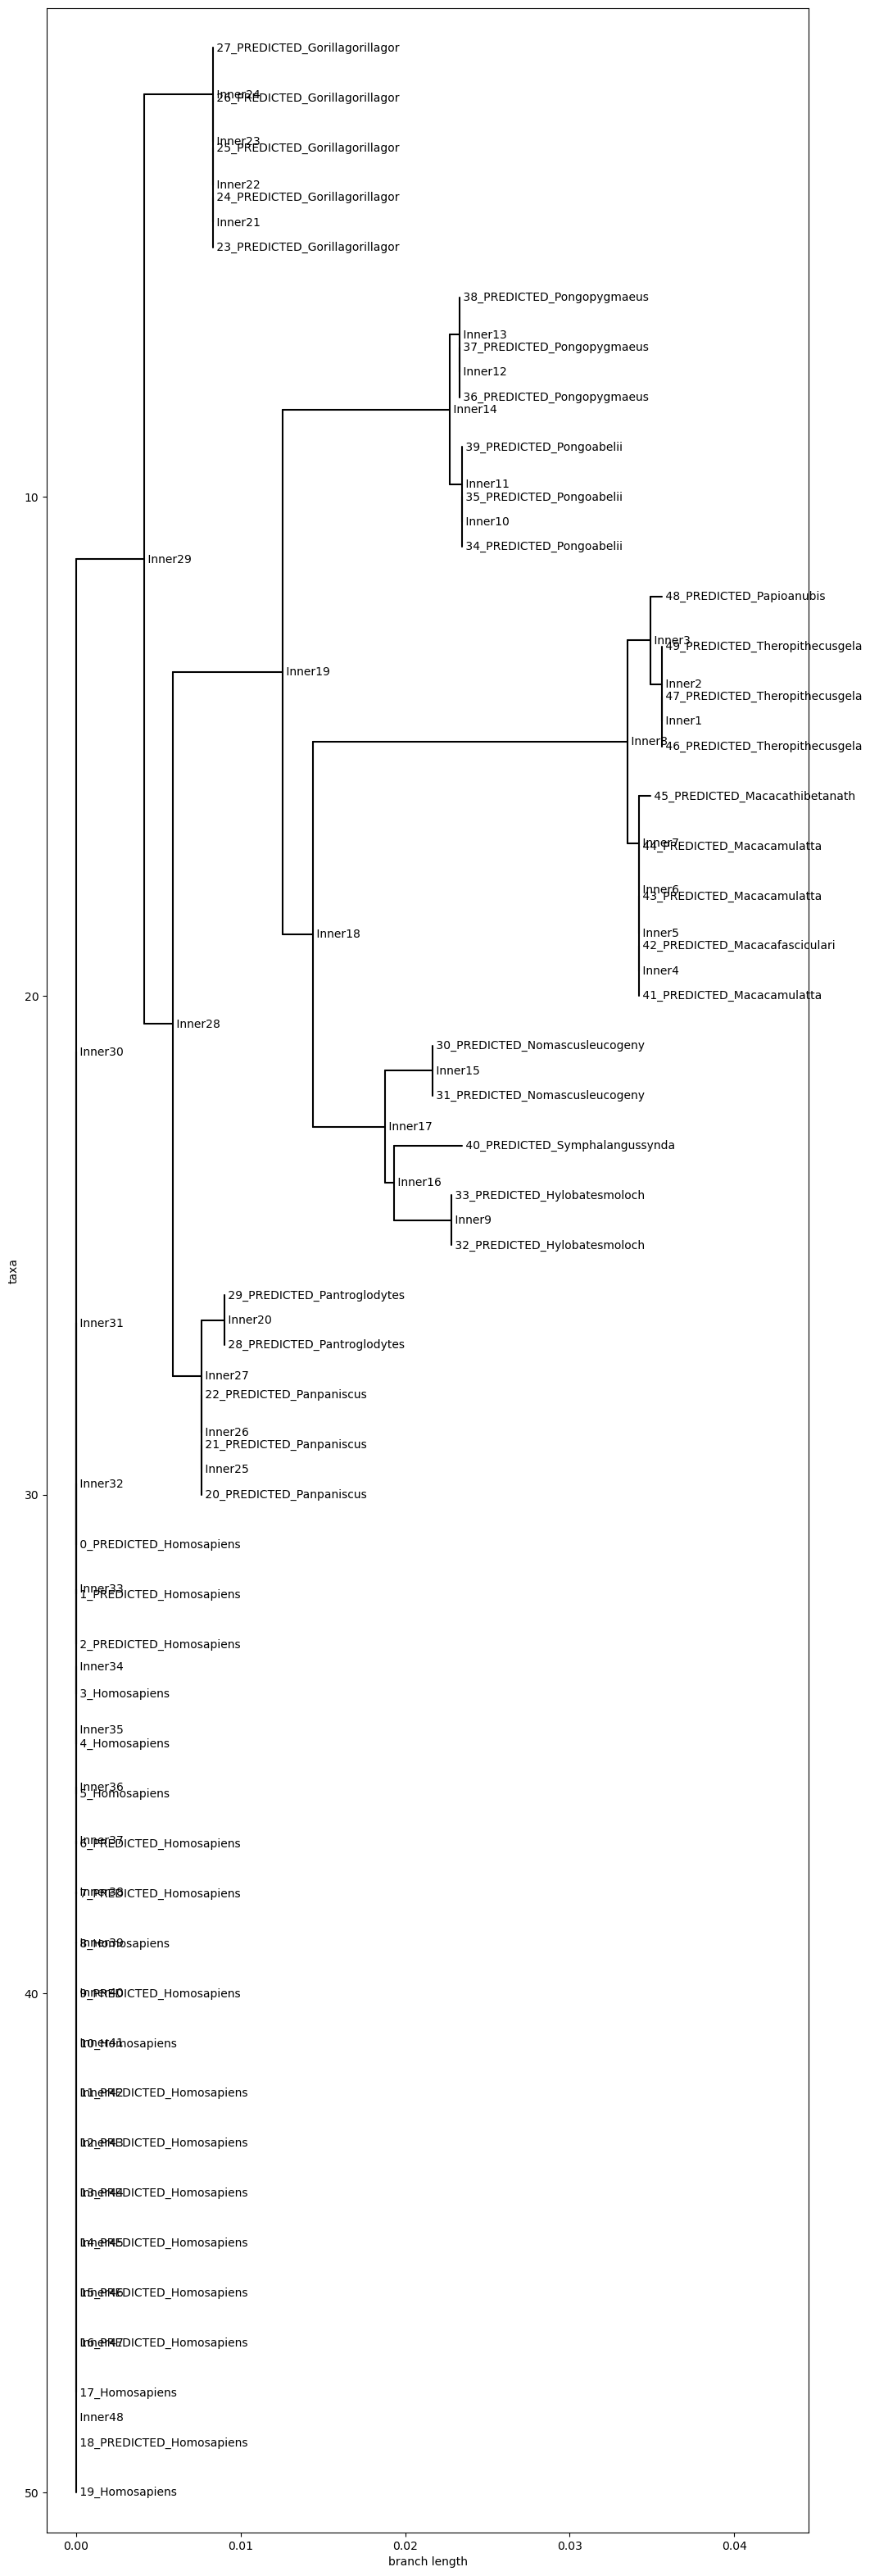

In [26]:
# read alignment
aln = AlignIO.read("./alignments/blast_sequences.aln", "clustal")

# compute distance matrix with identity model
calculator = DistanceCalculator("identity")
dm = calculator.get_distance(aln)

# construct tree
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

# save tree in phyloXML format
Phylo.write(tree, "./results/phylogenetic_tree.xml", "phyloxml")

# print and visualise tree
fig, ax = plt.subplots(figsize=(12, 40))

# do not put lambda function for branch labels like last time because i gets messy
Phylo.draw(tree, axes=ax)

# save file then close
output_filename = "./results/phylogenetic_tree_of_human_Akt1_blast_results.png"
fig.savefig(output_filename, dpi=300)
plt.close()

The gene names are cut off, but they are all a form of Akt1, as can be seen from the original file (`./data/blast_results.xml`). For my overall question, which is the most recent common ancestor `species` for this particular gene, the gene names are not important so I did not shape the code to show them in the tree. The seemingly duplicate species are actually different gene variants or predicted gene variants from the same species.

I found out that Biopython blast can indeed be used to find very similar species for a particular gene, such as Gorilla gorilla gorilla and Pan troglodytes (Chimpanzee). Macaca mulata (rhesus monkey) is also in the tree. However, because Homo sapiens grows directly from the root of the tree, we cannot see any common ancestors for the Akt1 gene. I cannot answer the question with which in min I wrote this part of the notebook. What we still can conclude is the following:
- The Akt1 gene as it exist in Homo sapiens is the most evolutionary conserved in Gorilla gorilla gorilla, Pan troglodytes, Pan paniscus, Pongo abelii, and Pongo pygmaeus, with Gorilla gorilla gorilla being the closest match.
- Most other closely related species are also all apes.
- Non-apes include Macaca mulatta, Macaca thibetana, Macaca fascicularis, Papio anubis, and Theropithecus gelada, which are all monkeys.

## Conclusion

The original question I started this notebook with was:

- Is there evidence for evolutionary pressure on the Akt1 protein?

I had the hypothesis that because Akt1 is essential for cellular function, I expect that there is evolutionary pressure on some parts of the protein, in particular the sequences (residues) that fall within a specific domain with its own function, such as the PH or catalytic domain.

Any specic domains I could not identify, but there certainly is evidence for evolutionary pressure from longer stretches of identical sequences in 5 of 6 proteins. The phylogenetic trees from the gene and protein sequences which show that some species are closely related support this conclusion, in addition to the BLAST search of the human coding sequence which returned 50 hits, all from Akt1 genes from multiple species.